In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import seaborn as sns, pandas as pd, numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures, PowerTransformer
from sklearn.metrics import make_scorer,f1_score,accuracy_score,confusion_matrix,roc_auc_score,roc_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

def minha_metrica(y_true, y_pred):
    threshold = 0.5  # Defina o threshold desejado
    

    # Calcule o true positive rate para o threshold dado
    tp = np.sum((y_true == 1) & (y_pred >= threshold))
    fn = np.sum((y_true == 1) & (y_pred < threshold))
    tpr = tp / (tp + fn)

    # Calcule o true negative rate para o threshold dado
    tn = np.sum((y_true == 0) & (y_pred < threshold))
    fp = np.sum((y_true == 0) & (y_pred >= threshold))
    tnr = tn / (tn + fp)

    # Calcule o produto dos passos 1 e 2
    product = tpr * tnr

    # Retorne a raiz quadrada do passo 3
    return np.sqrt(product)

In [2]:
data = pd.read_csv("dados_classificacao/dados_hospital.csv", sep=',')

target = 'no_show'

le = LabelEncoder()
for cl in data.columns:
    if data[cl].dtypes==np.object0:
        data[cl] = le.fit_transform(data[cl])
data.dtypes.value_counts()

X, y = data.drop([target,'cancer'], axis=1), data[target]

X_traina, X_testa, y_traina, y_testa = train_test_split(X,y,test_size=0.2, stratify=y, random_state=42)


Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 2.5 * IQR
limite_superior = Q3 + 2.5 * IQR
data_sem_outliers = data[(data >= limite_inferior) & (data <= limite_superior)]

data_sem_outliers.dropna(inplace=True)

X_so = data_sem_outliers.drop([target,'cancer'], axis=1)
y_so = data_sem_outliers[target]
X_trainb, X_testb, y_trainb, y_testb = train_test_split(X_so,y_so,test_size=0.2, stratify=y_so, random_state=0)

dt = [[X_traina,y_traina,X_testa,y_testa],[X_trainb,y_trainb,X_testb,y_testb]]

[0.55956185 0.56967967 0.57249935] [0.44029595409662864, 0.3810375670840787]
[[ 58  53]
 [985 581]]


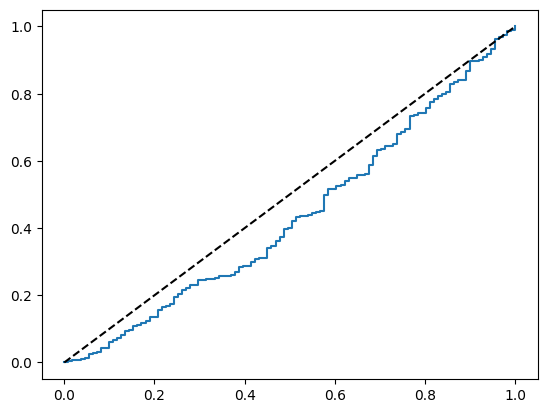

In [261]:
X_train,y_train,X_test,y_test = dt[0]

my_scorer = make_scorer(minha_metrica,greater_is_better=True)

poly = PolynomialFeatures(degree = 1)
pipe = Pipeline([(('poli',poly)),('escala',StandardScaler()),('modelo', LogisticRegression(penalty='l2',class_weight='balanced',C = 10.,max_iter=1000000))]) 

cvr = cross_validate(pipe, X_train, y_train, cv = 3, scoring=my_scorer, return_estimator=True)
scores = cvr['test_score']
estimators = cvr['estimator']
best_model = estimators[np.argmax(cvr['test_score'])]
y_pred = best_model.predict_proba(X_test)[:,0]
print(scores,[minha_metrica(y_test,y_pred),accuracy_score(y_test,y_pred>=0.5)])
print(confusion_matrix(y_pred=y_pred>=0.5,y_true=y_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='Curva ROC')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')

[0.59910244 0.61755526 0.62351751] [0.51051781999896, 0.5158020274299344]
[[ 56  55]
 [757 809]]


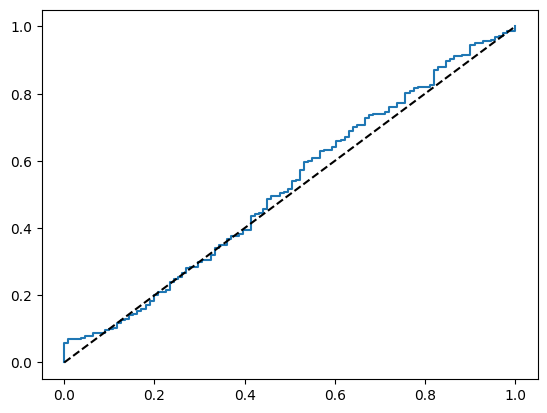

In [341]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE

balancear = SMOTE()

X_train,y_train,X_test,y_test = dt[0]
X_resampled, y_resampled = balancear.fit_resample(X_train, y_train)

my_scorer = make_scorer(minha_metrica,greater_is_better=True)

poly = PolynomialFeatures(degree = 4)
pipe = Pipeline([(('poli',poly)),('escala',StandardScaler()),('modelo', LogisticRegression(penalty='l2',C = .00000000000025,max_iter=1000000))]) 
# pipe = Pipeline([(('poli',poly)),('trasforma',PowerTransformer()),('modelo', LogisticRegression(penalty='l2',C = .0000000000010,max_iter=1000000))]) 

cvr = cross_validate(pipe, X_resampled, y_resampled, cv= 3, scoring=my_scorer, return_estimator=True)
scores = cvr['test_score']
estimators = cvr['estimator']
best_model = estimators[np.argmax(cvr['test_score'])]
y_pred = best_model.predict_proba(X_test)[:,0]
print(scores,[minha_metrica(y_test,y_pred),accuracy_score(y_test,y_pred>=0.5)])
print(confusion_matrix(y_pred=y_pred>=0.5,y_true=y_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='Curva ROC')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')

[0.26371832 0.24022599 0.26495988] [0.20699624428065286, 0.1037567084078712]
[[  98   13]
 [1490   76]]


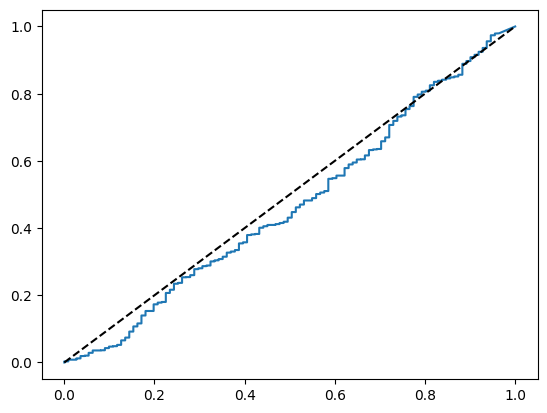

In [196]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours, NeighbourhoodCleaningRule, OneSidedSelection

balancear = TomekLinks()

X_train,y_train,X_test,y_test = dt[0]
X_resampled, y_resampled = balancear.fit_resample(X_train, y_train)

my_scorer = make_scorer(minha_metrica,greater_is_better=True)

poly = PolynomialFeatures(degree = 3)

pipe = Pipeline([(('poli',poly)),('escala',StandardScaler()),('modelo', LogisticRegression(penalty='l2',C = 50.050,max_iter=1000000))]) 
# pipe = Pipeline([('trasforma',PowerTransformer()),('modelo', LogisticRegression(penalty='l2',C = .005050,max_iter=1000000))]) 

cvr = cross_validate(pipe, X_resampled, y_resampled, cv = 3, scoring = my_scorer, return_estimator=True)
scores = cvr['test_score']
estimators = cvr['estimator']
best_model = estimators[np.argmax(cvr['test_score'])]
y_pred = best_model.predict_proba(X_test)[:,0]
print(scores,[minha_metrica(y_test,y_pred),accuracy_score(y_test,y_pred>=0.5)])
print(confusion_matrix(y_pred=y_pred>=0.5,y_true=y_test))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='Curva ROC')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')